In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

In [19]:
X_train = pd.read_csv('../../datasets/Toy/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Toy/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Toy/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Toy/y_test.csv',index_col=0)  

split_ratio = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=split_ratio, random_state=42)
X_train_con=X_train.drop(columns=['x1'])
X_val_con=X_val.drop(columns=['x1'])
X_test_con=X_test.drop(columns=['x1'])

In [20]:
X_train_con

,x0,x2,x3,x4,x5
97651,0.554358,0.052736,0.505530,165.739262,1
45938,-0.435011,0.893536,0.800912,158.539590,0
66358,2.746904,-0.283311,1.418933,163.893527,1
62628,3.671753,1.066627,3.190901,154.704743,1
89874,3.282473,0.571231,1.972984,160.736258,1
...,...,...,...,...,...
145783,0.317447,-1.194427,2.243835,164.407875,1
58423,1.532524,-1.401718,2.353885,163.188793,0
53791,0.215282,-0.135332,0.649558,168.378115,1
156820,0.290969,0.682983,1.076200,165.634839,1


In [21]:
X_train.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'], dtype='object')

In [5]:
y_test

,y
73032,1617.993424
193271,1780.596763
66713,1679.185088
92710,1842.917089
12849,1614.700338
...,...
90175,1620.016923
186257,1619.385255
98550,1658.525709
28035,1621.077476


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_con)
X_val_scaled = scaler.transform(X_val_con)
X_test_scaled = scaler.transform(X_test_con)

In [23]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [24]:
config={'batch_size': 53, 'lr': 0.00038488608963589005, 'num_epochs': 100, 'hidden_layers': 3, 'hidden_units': [64, 32, 32], 'dropout': False, 'dropout_array': [0.38283509966903684, 0.14655095633529086, 0.5393755103727268], 'activation': nn.ReLU(), 'norm': True,'patience': 20}

input_dim = X_train_scaled.shape[1]
output_dim = 1

In [25]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
val_ds = TensorDataset(torch.Tensor(X_val_scaled), torch.Tensor(y_val.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [26]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [27]:
net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])

In [28]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
net = net.to(device)

In [29]:
summary(net,input_size=(5,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                    [-1, 5]              10
            Linear-2                   [-1, 64]             384
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                   [-1, 32]           1,056
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 1]              33
Total params: 3,563
Trainable params: 3,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [30]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [31]:
criterion = RMSELoss()
optimizer = optim.Adam(net.parameters(), lr=config["lr"])

In [45]:
def train_net(net, train_loader, criterion, optimizer, device):
    net.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader), net


def test_net(net, test_loader, criterion, device):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    return test_loss / len(test_loader)


def train(config):
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
    net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])
    criterion = RMSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience = config['patience']
    early_stop = False

    for epoch in range(config["num_epochs"]):
        train_loss,net = train_net(net, train_loader, criterion, optimizer, device)
        val_loss = test_net(net, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = config['patience']
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping...")
                early_stop = True
                break

    if not early_stop:
        print("Training complete.")

    return train_losses, val_losses, net


In [46]:
train_losses, val_losses, mod = train(config)

Epoch [1/100], Train Loss: 392.6650, Test Loss: 62.2483
Epoch [2/100], Train Loss: 60.5808, Test Loss: 22.5027
Epoch [3/100], Train Loss: 25.5723, Test Loss: 11.0856
Epoch [4/100], Train Loss: 14.8443, Test Loss: 9.8757
Epoch [5/100], Train Loss: 12.1015, Test Loss: 7.9051
Epoch [6/100], Train Loss: 11.1151, Test Loss: 10.7783
Epoch [7/100], Train Loss: 10.8474, Test Loss: 6.8381
Epoch [8/100], Train Loss: 10.6137, Test Loss: 7.8350
Epoch [9/100], Train Loss: 10.4767, Test Loss: 7.5540
Epoch [10/100], Train Loss: 10.5473, Test Loss: 6.3963
Epoch [11/100], Train Loss: 10.4404, Test Loss: 9.0901
Epoch [12/100], Train Loss: 10.5526, Test Loss: 6.5355
Epoch [13/100], Train Loss: 10.5379, Test Loss: 6.4227
Epoch [14/100], Train Loss: 10.3878, Test Loss: 7.5827
Epoch [15/100], Train Loss: 10.3152, Test Loss: 6.5053
Epoch [16/100], Train Loss: 10.3406, Test Loss: 6.2684
Epoch [17/100], Train Loss: 10.3708, Test Loss: 8.9725
Epoch [18/100], Train Loss: 10.3107, Test Loss: 7.5543
Epoch [19/100]

In [47]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

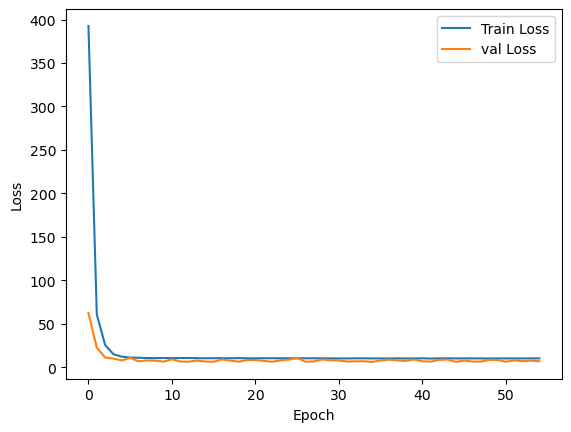

In [48]:
plot_losses(train_losses, val_losses)

In [49]:
def plot_predictions(net, data_loader, device):
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


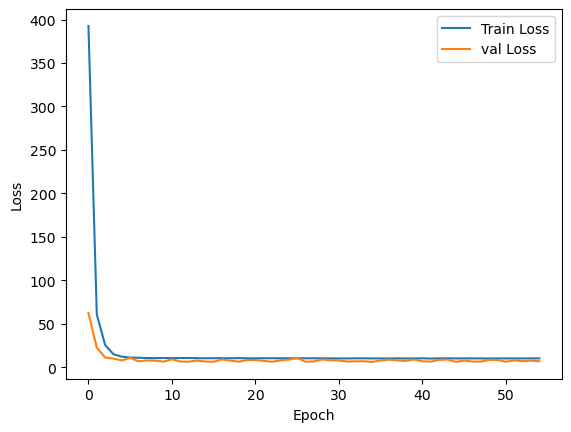

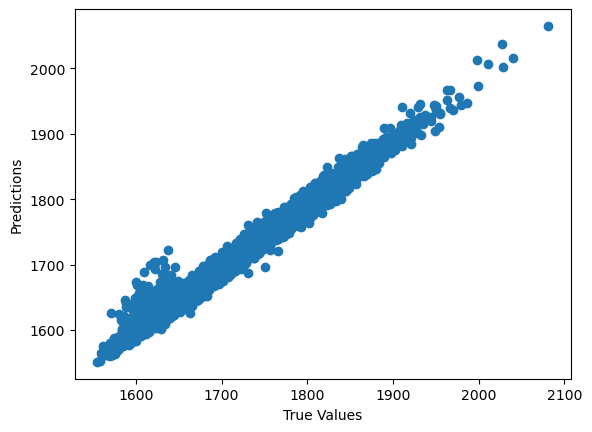

R^2 score: 0.9821588577235638
Train_loss: 6.924129009246826
Validation_loss: 6.927171230316162
Test_loss: 6.888339042663574


In [50]:
#train_losses, test_losses = train(config)
plot_losses(train_losses, val_losses)
plot_predictions(mod, test_loader, device)
y_true = y_test
y_pred = mod(torch.Tensor(X_test_scaled).to(device)).cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
print("R^2 score:", r2)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
print("Train_loss:",criterion(mod(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item())
print("Validation_loss:",criterion(mod(torch.Tensor(X_val_scaled).to(device)),y_val_tensor).item())
print("Test_loss:",criterion(mod(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item())



In [41]:
mod

Net(
  (net): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [51]:
torch.save(mod.state_dict(), '../../Models/toy_model_confounder_9821')

In [58]:
net.load_state_dict(torch.load('./Models/toy_model_confounder'))
net.eval()

Net(
  (net): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)